In [1]:
pip install downcast

In [2]:
pip install catboost

     |████████████████████████████████| 69.2MB 48kB/s 


In [62]:
import pandas as pd
import pickle
import numpy as np
from downcast import reduce
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")
import random 
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor


In [61]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Read all the csv files**

In [3]:
calendar=pd.read_csv('/content/gdrive/MyDrive/m5-accuracy/calendar.csv') # Read calendar.csv file, Contains information about the dates on which the products are sold
sales_evaluation=pd.read_csv('/content/gdrive/MyDrive/m5-accuracy/sales_train_evaluation.csv') #Contains the historical daily unit sales data per product and store [d_1 - d_1941]
sell_prices=pd.read_csv('/content/gdrive/MyDrive/m5-accuracy/sell_prices.csv') # Contains information about the price of the products sold per store and date.

In [6]:
# reframing the sales(sales_train_evaluation.csv) dataframe in such a way that it can be merged with other csv files.
data = pd.melt(sales_evaluation, 
               id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
               var_name='day', value_name='sales')
data.head(2)

,id,item_id,dept_id,cat_id,store_id,state_id,day,sales
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


In [7]:
#  merging calendar dataframe with data 
data = data.merge(calendar, left_on='day', right_on='d')
# merging prices dataframe with data 
data = data.merge(sell_prices,on=['store_id','item_id', 'wm_yr_wk'], how='left')

In [9]:
data.shape

(59181090, 23)

In [10]:
#check all null values
print("Number of null values :",data.isna().sum())

Number of null values : id                     0
item_id                0
dept_id                0
cat_id                 0
store_id               0
state_id               0
day                    0
sales                  0
date                   0
wm_yr_wk               0
weekday                0
wday                   0
month                  0
year                   0
d                      0
event_name_1    54363670
event_type_1    54363670
event_name_2    59059130
event_type_2    59059130
snap_CA                0
snap_TX                0
snap_WI                0
sell_price      12299413
dtype: int64


**Perform Mean Imputation in sell_price data frame because there is a lot of missing/null values in the sell price feature** 

The missing values can be imputed with the mean of that particular feature/data variable. That is, the null or missing values can be replaced by the mean of the data values of that particular data column or dataset

In [11]:
# mean imputation on sell_price column values
data['sell_price'].fillna(data.groupby('id')['sell_price'].transform('mean'), inplace=True)
data.head(5)

,id,item_id,dept_id,cat_id,store_id,state_id,day,sales,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,8.281250
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,3.970703
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,2.970703
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,4.527344
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,2.943359


In [12]:
# we are remove 'd_' from day column 
data['day'] = data['day'].apply(lambda x: x.split('_')[1]).astype(int)

#since weekday's are represented as wday with numbers and d is a duplicate column.
data.drop(['d','weekday','date'], axis=1, inplace=True)

# **Feature Engineering For Time Series data**

**1. Feature 'is_weekend'**

In [13]:
# 'is_weekend' feature to check weekend or not
data['is_weekend'] = (data['wday']<=2).astype(np.int8)
data.head(2)

,id,item_id,dept_id,cat_id,store_id,state_id,day,sales,wm_yr_wk,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,is_weekend
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1,0,11101,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,8.281250,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1,0,11101,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,3.970703,1


**2. Feature 'per_day_events'**  Total number of events in a day 

In [14]:
cat=['event_name_1','event_type_1','event_name_2','event_type_2']
for i in cat:
  #https://stackoverflow.com/questions/53664948/pandas-fillna-throws-valueerror-fill-value-must-be-in-categories
  data[i] = data[i].cat.add_categories('no_event')
  data[i].fillna('no_event',inplace=True)

In [15]:
# first we calculate event_type_1 if event then calcualte 1 otherwise 0
data['per_day_events']=data['event_type_1'].map(lambda x: 0 if x=='no_event' else 1) 
# second we store only event_type_2 if the value is present 
non_zero_num = data.index[data['event_type_2']!='no_event'].tolist()

# for loop 
for i in non_zero_num:
  data['per_day_events'][i]+=1 
#downcast the data type
data['per_day_events']=data['per_day_events'].astype(np.int8)

**3. Lag features**

we are predicting the sales prices next day for walmart. So, the previous day’s sales price is important to make a prediction,In other words, the value at time t is greatly affected by the value at time t-1. The past values are known as lags, so t-1 is lag 1, t-2 is lag 2, and so on.

In [16]:
#Calculating Leg features
lags = [28,30,35,42,49,56]
for lag in tqdm(lags):
    data["lag_" + str(lag)] = data.groupby("id")["sales"].shift(lag)

100%|██████████| 6/6 [00:15<00:00,  2.61s/it]


**4. Rolling median features**

In [ ]:
# Calculating Rolling Median features 
data['rolling_median_'+str(7)] = data.groupby(['id'])['sales'].transform(lambda x: x.rolling(7).median())
data['rolling_median_'+str(14)] = data.groupby(['id'])['sales'].transform(lambda x: x.rolling(14).median())
data['rolling_median_'+str(28)] = data.groupby(['id'])['sales'].transform(lambda x: x.rolling(28).median())

**5. Rolling Window Statistics**

How about calculating some statistical values based on past values? This method is called the rolling window method because the window would be different for every data point.

I'll be calculating weekly rolling avearge of the items sold.

![](https://cdn.analyticsvidhya.com/wp-content/uploads/2019/11/3hotmk.gif)




In [ ]:
#calculateing rolling sold feature
data['rolling_sold_mean'] = data.groupby(['id'])['sales'].transform(lambda x: x.rolling(window=7).mean()).astype(np.float16)

**6. Expanding Window Statistics**

This is simply an advanced version of the rolling window technique. In the case of a rolling window, the size of the window is constant while the window slides as we move forward in time. Hence, we consider only the most recent values and ignore the past values. Here’s a gif that explains how our expanding window function works:
![](https://cdn.analyticsvidhya.com/wp-content/uploads/2019/12/output_B4KHcT.gif)

I'll be calculating expanding avearge of the items sold. More features like expanding min, max or sum can also be calculated. Also, same features can be calculated for revenue as well.

In [ ]:
#Calculate expending window feature
data['expanding_sold_mean'] = data.groupby(['id'])['sales'].transform(lambda x: x.expanding(2).mean()).astype(np.float16)

In [ ]:
data.head()

In [53]:
#filling all the nan values to zero
feature_window = ['lag_28','lag_30','lag_35','lag_42','lag_49','lag_56','rolling_median_7','rolling_median_14','rolling_median_28','rolling_sold_mean','expanding_sold_mean']
for i in feature_window:
  data[i]=data[i].fillna(0) 

**Label-Encoding**

In [54]:
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder() 
category=['event_name_1','event_type_1','event_name_2','event_type_2','id','item_id','dept_id','cat_id','store_id','state_id']
for i in tqdm(category):
  labelencoder.fit(data[i].values.astype(str))
  data[i] = labelencoder.fit_transform(data[i].values.astype(str))


100%|██████████| 10/10 [03:52<00:00, 23.20s/it]


In [55]:
data.head(5)

,id,item_id,dept_id,cat_id,store_id,state_id,day,sales,wm_yr_wk,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_28,lag_30,lag_35,lag_42,lag_49,lag_56,rolling_median_7,rolling_median_14,rolling_median_28,rolling_sold_mean,expanding_sold_mean,is_weekend,per_day_events
45735000,4859,488,3,1,0,0,1501,0,11506,3,3,2015,17,4,0,0,1,1,1,8.257812,0.0,2.0,0.0,1.0,1.0,2.0,0.0,0.5,0.0,0.714355,0.209839,0,0
45735001,4870,489,3,1,0,0,1501,1,11506,3,3,2015,17,4,0,0,1,1,1,3.970703,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.285645,0.239868,0,0
45735002,4881,490,3,1,0,0,1501,0,11506,3,3,2015,17,4,0,0,1,1,1,2.970703,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.142822,0.055298,0,0
45735003,4893,492,3,1,0,0,1501,1,11506,3,3,2015,17,4,0,0,1,1,1,4.640625,0.0,10.0,0.0,3.0,8.0,2.0,2.0,1.0,1.5,2.857422,1.638672,0,0
45735004,4904,493,3,1,0,0,1501,1,11506,3,3,2015,17,4,0,0,1,1,1,2.880859,0.0,5.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.428711,0.919434,0,0


In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13446090 entries, 45735000 to 59181089
Data columns (total 33 columns):
 #   Column               Dtype  
---  ------               -----  
 0   id                   int64  
 1   item_id              int64  
 2   dept_id              int64  
 3   cat_id               int64  
 4   store_id             int64  
 5   state_id             int64  
 6   day                  int16  
 7   sales                int16  
 8   wm_yr_wk             int16  
 9   wday                 int8   
 10  month                int8   
 11  year                 int16  
 12  event_name_1         int64  
 13  event_type_1         int64  
 14  event_name_2         int64  
 15  event_type_2         int64  
 16  snap_CA              int8   
 17  snap_TX              int8   
 18  snap_WI              int8   
 19  sell_price           float16
 20  lag_28               float16
 21  lag_30               float16
 22  lag_35               float16
 23  lag_42               fl

In [ ]:
# Save the file so no need to run merge code again
with open('/content/gdrive/MyDrive/m5-accuracy/MODEL_DATA.pkl', 'wb') as f:
    pickle.dump(data, f)

In [63]:
# Read save data file
data = pd.read_pickle("/content/gdrive/MyDrive/m5-accuracy/MODEL_DATA.pkl")
data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,day,sales,wm_yr_wk,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_28,lag_30,lag_35,lag_42,lag_49,lag_56,rolling_median_7,rolling_median_14,rolling_median_28,rolling_sold_mean,expanding_sold_mean,is_weekend,per_day_events
0,14370,1437,3,1,0,0,1,0,11101,1,1,2011,30,4,4,2,0,0,0,8.281250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
1,14380,1438,3,1,0,0,1,0,11101,1,1,2011,30,4,4,2,0,0,0,3.970703,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
2,14390,1439,3,1,0,0,1,0,11101,1,1,2011,30,4,4,2,0,0,0,2.970703,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
3,14400,1440,3,1,0,0,1,0,11101,1,1,2011,30,4,4,2,0,0,0,4.527344,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
4,14410,1441,3,1,0,0,1,0,11101,1,1,2011,30,4,4,2,0,0,0,2.943359,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0


# **MODELS**

**Performance Matrix** 

In [64]:
def rmse(pred,value):
    return np.sqrt(((pred-value)**2).mean())

Taken data after 1000 days (because of less memory )

In [65]:
data = data[data['day']>1000]

# **Train, Test, Cross Validation for the model**

In [71]:

# Now we are splitting our data into, Train, Test, Cross Validate.
# Being a time series model, we are splitting the data based on time.

def train_val_test_split(data):
    '''
    This function is used to split the dataset into train,validation and test dataset
    Parameters:
    1.data : dataset need to be split
    
    Returns:
    train dataset,validation dataset,test dataset
    '''
    
    #Product details upto day 1913 is used as training dataset
    Xtrain = data[data['day']<=1913]
    ytrain = Xtrain['sales']
    Xtrain.drop('sales',axis = 1,inplace = True)
    
    Xval = data[(data['day']>=1914) & (data['day']>1913)]
    yval = Xval['sales']
    Xval.drop(['sales'],axis = 1,inplace = True)
    
    Xtest = data[(data['day']>=1914)]
    Xtest.drop(['sales'],axis = 1,inplace = True)
    
    print("Train dataset",Xtrain.shape,ytrain.shape)
    print("Validation dataset",Xval.shape,yval.shape)
    print("Test dataset",Xtest.shape)
    return(Xtrain,ytrain,Xval,yval,Xtest)

In [72]:
Xtrain,ytrain,Xval,yval,Xtest=train_val_test_split(data)

Train dataset (27837370, 32) (27837370,)
Validation dataset (853720, 32) (853720,)
Test dataset (853720, 32)


In [73]:
def generate_submission_file(model,Xtest,file_name):

  sale_evl = pd.DataFrame()
  sale_val = pd.DataFrame()
  sale_evl['id'] = sales_evaluation['id'] 
  count = 1
  
  for i in range(1914,1942):
    sale_evl['F'+str(count)]=model.predict(Xtest[Xtest['day']==(i)]) 
    count += 1

  sale_evl["id"] = sale_evl["id"].apply(lambda x: x.replace('evaluation','validation'))
  sale_val = sale_evl.copy()

  sale_val["id"] = sale_evl["id"].apply(lambda x: x.replace('validation','evaluation'))
  submission = pd.concat([sale_evl,sale_val]).reset_index().drop(['index'],axis=1)

  submission.to_csv(file_name,index = False)
  print("Submission file with name "+file_name+" created successfully")


# **1.LINEAR REGRESSION**




In [74]:
model = LinearRegression(n_jobs=-1)
model.fit(Xtrain,ytrain)

ypred = model.predict(Xval)

print("Rmse: {}".format(rmse(ypred,yval)))

Rmse: 1.8061939243997174


In [75]:
generate_submission_file(model,Xtest,"linear_regression.csv")

Submission file with name linear_regression.csv created successfully


In [76]:
predict_data = pd.read_csv('linear_regression.csv')
predict_data.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.772858,0.662628,0.501465,0.367798,0.482208,0.898163,1.700470,1.343292,1.635773,1.697846,1.276062,1.494476,1.479492,0.971741,0.825195,1.174530,1.231323,1.086975,1.373291,2.006104,1.822846,1.045288,0.956818,0.716156,1.272980,1.156006,0.943054,1.205566
1,HOBBIES_1_002_CA_1_validation,0.036743,0.121613,-0.037231,0.076385,0.022705,0.295349,0.348785,0.107208,-0.079163,0.035400,-0.026123,0.098816,0.395660,0.255280,0.097443,0.032806,-0.106903,-0.081177,-0.104706,0.349670,0.686249,0.507385,0.614136,0.660583,0.640289,0.600128,0.799591,0.482422
2,HOBBIES_1_003_CA_1_validation,0.399353,0.306274,0.254852,0.414581,0.297150,0.870056,0.813324,0.498657,0.505768,0.413086,0.192169,0.661377,0.733460,0.976807,0.771088,0.727295,0.926117,1.092072,0.803741,0.951813,0.854462,0.489349,0.447723,0.348145,0.562225,0.931854,1.341065,1.162140
3,HOBBIES_1_004_CA_1_validation,1.818298,1.482391,1.915588,2.159760,2.249115,1.613831,2.340881,2.652527,2.529724,2.312500,1.879578,1.873352,2.514465,1.978851,1.152496,1.094757,1.528412,1.810608,1.679474,2.013824,1.567535,1.402252,0.821442,0.888916,1.343170,1.324097,2.074554,2.793854
4,HOBBIES_1_005_CA_1_validation,1.861023,1.655335,1.893066,1.897125,1.631226,1.586517,1.655335,1.321533,1.690918,1.643219,1.174744,1.688202,2.221710,2.212128,2.025940,1.730774,1.924652,2.129669,1.615814,1.562164,1.129059,0.748474,0.642365,0.440979,0.124207,0.336243,0.846832,1.116119


# **2. Decision Trees**

In [ ]:
model = DecisionTreeRegressor()
model.fit(Xtrain,ytrain)

ypred = model.predict(Xval)
print("Rmse: {}".format(rmse(ypred,yval)))

Rmse: 2.6658280475533225


In [ ]:
generate_submission_file(model,Xtest,"DecisionTreeRegressor.csv")

Submission file with name DecisionTreeRegressor.csv created successfully


**Decision Trees with Hyperparameters**

In [ ]:
# We are training our model with multiple parameter values to get the best parameter to be used for the model.

# We are randomly creating values to chose the best model out of it.

for i in tqdm(range(10)): 
  max_depth = random.randint(1,150)
  min_samples_split = random.randint(15,500)
  min_samples_leaf = random.randint(15,400)

  dt=DecisionTreeRegressor(max_depth=max_depth,min_samples_split=min_samples_split,max_leaf_nodes=min_samples_leaf)

  dt.fit(Xtrain,ytrain)

  # After training the model, we are trying to predict the model on X_val to check it's accuracy
  ypred=dt.predict(Xval)

  # Now that it has predicted the values for X_val, we are calculating it's rmse
  rmse_result = rmse(ypred,yval)

  print("\n\nmax_depth: {}".format(max_depth),"  min_samples_split: {}".format(min_samples_split),"  min_samples_leaf: {}".format(min_samples_leaf),"  Rmse: {}".format(rmse_result))
 

 10%|█         | 1/10 [01:34<14:06, 94.07s/it]



max_depth: 75   min_samples_split: 417   min_samples_leaf: 42   Rmse: 1.799398087789199


 20%|██        | 2/10 [03:29<13:22, 100.35s/it]



max_depth: 75   min_samples_split: 465   min_samples_leaf: 268   Rmse: 1.7761851109858502


 30%|███       | 3/10 [05:21<12:08, 104.03s/it]



max_depth: 110   min_samples_split: 97   min_samples_leaf: 202   Rmse: 1.7791837654323635


 40%|████      | 4/10 [07:11<10:33, 105.66s/it]



max_depth: 63   min_samples_split: 473   min_samples_leaf: 128   Rmse: 1.7798035389770968


 50%|█████     | 5/10 [08:30<08:09, 97.86s/it] 



max_depth: 95   min_samples_split: 32   min_samples_leaf: 15   Rmse: 1.8770095332941115


 60%|██████    | 6/10 [10:25<06:51, 102.78s/it]



max_depth: 45   min_samples_split: 242   min_samples_leaf: 252   Rmse: 1.7786404203935233


 70%|███████   | 7/10 [12:04<05:04, 101.64s/it]



max_depth: 146   min_samples_split: 318   min_samples_leaf: 67   Rmse: 1.7882147725951367


 80%|████████  | 8/10 [13:59<03:31, 105.91s/it]



max_depth: 111   min_samples_split: 351   min_samples_leaf: 269   Rmse: 1.7793372871432998


 90%|█████████ | 9/10 [16:02<01:50, 110.76s/it]



max_depth: 70   min_samples_split: 499   min_samples_leaf: 358   Rmse: 1.7768393858393399


100%|██████████| 10/10 [17:51<00:00, 107.11s/it]



max_depth: 29   min_samples_split: 429   min_samples_leaf: 163   Rmse: 1.7791681640314132


In [ ]:
# After running several combinations, we found these parameter values to give best result
max_depth = 75
min_samples_split = 465
min_samples_leaf = 268 

In [ ]:
# Now that we have found the best model which has the lowest RMSE score, we are using that parameter values to retrain the model.

dt = DecisionTreeRegressor(max_depth = max_depth,
                           min_samples_split = min_samples_split,
                           max_leaf_nodes = min_samples_leaf)

dt.fit(Xtrain,ytrain)
ypred = dt.predict(Xval)

print("max_depth: {}".format(max_depth),"  min_samples_split: {}".format(min_samples_split),"  min_samples_leaf: {}".format(min_samples_leaf),"  Rmse: {}".format(rmse(ypred,yval)))

max_depth: 75   min_samples_split: 465   min_samples_leaf: 268   Rmse: 1.7761851109858502


In [ ]:
generate_submission_file(dt,Xtest,"DecisionTreeRegressorWith_hyperparameters.csv")

Submission file with name DecisionTreeRegressorWith_hyperparameters.csv created successfully


In [ ]:
predict_data = pd.read_csv('DecisionTreeRegressorWith_hyperparameters.csv')
predict_data.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.979320,0.783615,0.661922,0.528860,0.528860,0.940913,1.812153,1.371890,1.371890,1.371890,1.371890,1.371890,1.550595,0.940913,0.979320,1.186091,1.186091,0.979320,1.371890,2.039826,1.812153,1.186091,0.979320,0.783615,1.186091,1.371890,0.940913,1.288131
1,HOBBIES_1_002_CA_1_validation,0.150229,0.294135,0.150229,0.150229,0.150229,0.150229,0.150229,0.150229,0.000000,0.150229,0.150229,0.150229,0.150229,0.150229,0.150229,0.150229,0.000000,0.000000,0.000000,0.150229,0.521529,0.528860,0.661922,0.661922,0.661922,0.661922,0.696498,0.294135
2,HOBBIES_1_003_CA_1_validation,0.661922,0.528860,0.528860,0.661922,0.528860,0.940913,0.940913,0.661922,0.661922,0.528860,0.401017,0.661922,0.696498,0.940913,0.783615,0.783615,0.979320,0.979320,0.783615,0.940913,0.696498,0.528860,0.528860,0.401017,0.661922,0.979320,1.288131,0.940913
3,HOBBIES_1_004_CA_1_validation,1.767407,1.767407,1.767407,2.101722,2.101722,1.812153,2.316107,2.430754,2.430754,2.101722,2.101722,1.767407,2.316107,2.039826,1.371890,1.371890,1.536879,1.767407,1.536879,1.812153,1.288131,1.186091,0.979320,0.979320,1.371890,1.186091,1.812153,2.745164
4,HOBBIES_1_005_CA_1_validation,1.767407,1.536879,1.767407,1.767407,1.767407,1.812153,1.812153,1.371890,1.767407,1.767407,1.371890,1.767407,2.745164,2.745164,2.101722,1.767407,2.101722,2.101722,1.767407,1.812153,1.288131,0.979320,0.979320,0.661922,0.401017,0.661922,0.940913,0.940913


# **3. Random-Forest**

In [ ]:
# We are training our model with multiple parameter values to get the best parameter to be used for the model.

# We are randomly creating values to chose the best model out of it.

for i in range(10):
   max_depth = np.random.randint(1,10)
   min_samples_leaf = np.random.randint(2,10)
   n_estimators = np.random.randint(20,110)

   model = RandomForestRegressor(max_depth = max_depth,
                                 min_samples_leaf = min_samples_leaf,
                                 n_estimators = n_estimators,n_jobs =- 1)
   
   model.fit(Xtrain,ytrain)

   # After training the model, we are trying to predict the model on X_val to check it's accuracy
   ypred = model.predict(Xval)
   
   # Now that it has predicted the values for X_val, we are calculating it's rmse
   print("\n\nmax_depth: {}".format(max_depth),"  min_samples_leaf: {}".format(min_samples_leaf),"  n_estimators: {}".format(n_estimators),"  Rmse: {}".format(rmse(ypred,yval)))
  



max_depth: 6   min_samples_leaf: 2   n_estimators: 93   Rmse: 1.781108167540244


max_depth: 9   min_samples_leaf: 7   n_estimators: 35   Rmse: 1.7631935085731751


max_depth: 6   min_samples_leaf: 9   n_estimators: 69   Rmse: 1.7808539129159384


max_depth: 7   min_samples_leaf: 8   n_estimators: 89   Rmse: 1.7731714406455934


max_depth: 6   min_samples_leaf: 3   n_estimators: 69   Rmse: 1.7812187286241985


max_depth: 2   min_samples_leaf: 9   n_estimators: 81   Rmse: 2.1811697488748516


max_depth: 6   min_samples_leaf: 2   n_estimators: 80   Rmse: 1.780816199005565


max_depth: 4   min_samples_leaf: 7   n_estimators: 96   Rmse: 1.848275455869368


max_depth: 8   min_samples_leaf: 8   n_estimators: 95   Rmse: 1.767726436707459


max_depth: 1   min_samples_leaf: 5   n_estimators: 46   Rmse: 2.8003783290150164


In [ ]:
# After running several combinations, we found these parameter values to give best result

max_depth = 9
min_samples_leaf = 7
n_estimators = 35

In [ ]:
# Now that we have found the best model which has the lowest RMSE score, we are using that parameter values to retrain the model.

model = RandomForestRegressor(max_depth = max_depth,
                              min_samples_leaf = min_samples_leaf,
                              n_estimators = n_estimators,
                              n_jobs=-1)

model.fit(Xtrain,ytrain)
ypred = model.predict(Xval)

print("\n\nmax_depth: {}".format(max_depth),"  min_samples_leaf: {}".format(min_samples_leaf),"  n_estimators: {}".format(n_estimators),"  Rmse: {}".format(rmse(ypred,yval)))




max_depth: 9   min_samples_leaf: 7   n_estimators: 35   Rmse: 1.7624789843881024


In [ ]:
generate_submission_file(model,Xtest,"RandomForest.csv")

Submission file with name RandomForest.csv created successfully


In [ ]:
predict_data = pd.read_csv('RandomForest.csv')
predict_data.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.921891,0.782471,0.653480,0.527324,0.528836,1.202359,1.927076,1.366019,1.296243,1.438493,1.296243,1.299507,1.536890,0.833041,0.921891,1.184924,1.184924,1.034297,1.299507,2.062424,2.022702,1.187468,0.919923,0.782471,1.184924,1.299507,1.208346,1.468947
1,HOBBIES_1_002_CA_1_validation,0.137013,0.269807,0.137013,0.137013,0.144007,0.194193,0.193610,0.137013,0.000000,0.137013,0.137013,0.144007,0.194032,0.193174,0.137013,0.137013,0.000000,0.000000,0.000000,0.194032,0.554715,0.527324,0.653480,0.653480,0.653480,0.687158,0.787421,0.377819
2,HOBBIES_1_003_CA_1_validation,0.656778,0.527324,0.527324,0.653480,0.528836,0.846070,0.846070,0.656778,0.653480,0.527324,0.395436,0.687158,0.787421,1.159384,0.782471,0.782471,0.919923,0.919923,0.793006,1.014286,0.787421,0.527324,0.527324,0.395436,0.653480,0.934035,1.468947,1.208346
3,HOBBIES_1_004_CA_1_validation,1.830556,1.666438,1.817535,2.002841,2.069318,1.789456,2.824628,2.335115,2.335115,2.274693,2.007007,1.694044,2.508452,1.982944,1.366019,1.438493,1.495723,1.684975,1.630652,2.114019,1.242286,1.187468,1.034297,1.034297,1.296243,1.196126,1.789456,2.829232
4,HOBBIES_1_005_CA_1_validation,1.684975,1.495723,1.684975,1.817535,1.688768,2.034540,1.789456,1.491980,1.825094,1.703423,1.438493,1.712581,2.590717,2.582390,2.016520,1.825094,2.007007,2.041514,1.688768,2.022702,1.410968,1.049189,0.919923,0.653480,0.395436,0.687158,1.033547,1.033547


# **4. LightGBM**

In [ ]:

# We are training our model with multiple parameter values to get the best parameter to be used for the model.

# We are randomly creating values to chose the best model out of it.
for i in tqdm(range(10)):
    lr = np.round(np.random.rand()/10,3)
    num_leaves = np.random.randint(30,150)
    min_data_in_leaf = np.random.randint(50,150)

    lgb = LGBMRegressor( learning_rate=lr ,
                            num_leaves=num_leaves ,
                            min_data_in_leaf=min_data_in_leaf)

    lgb.fit(Xtrain, ytrain)

    # After training the model, we are trying to predict the model on X_val to check it's accuracy
    y_pred = lgb.predict(Xval)

    # Now that it has predicted the values for X_val, we are calculating it's rmse
    acc = rmse(yval,y_pred)
    
    print(f"For learning rate {lr}, num_leaves {num_leaves} and min_data_in_leaf {min_data_in_leaf} the RMSE is {acc} ")
    print('*'*80)

 10%|█         | 1/10 [00:46<06:55, 46.16s/it]

For learning rate 0.045, num_leaves 128 and min_data_in_leaf 61 the RMSE is 1.7459042646118457 
********************************************************************************


 20%|██        | 2/10 [01:28<06:00, 45.07s/it]

For learning rate 0.028, num_leaves 83 and min_data_in_leaf 101 the RMSE is 1.768630982106965 
********************************************************************************


 30%|███       | 3/10 [02:10<05:07, 43.96s/it]

For learning rate 0.041, num_leaves 87 and min_data_in_leaf 149 the RMSE is 1.7497580251553326 
********************************************************************************


 40%|████      | 4/10 [02:43<04:05, 40.95s/it]

For learning rate 0.066, num_leaves 48 and min_data_in_leaf 143 the RMSE is 1.7461794191834472 
********************************************************************************


 50%|█████     | 5/10 [03:24<03:23, 40.70s/it]

For learning rate 0.037, num_leaves 80 and min_data_in_leaf 94 the RMSE is 1.7531007369407354 
********************************************************************************


 60%|██████    | 6/10 [04:00<02:38, 39.51s/it]

For learning rate 0.022, num_leaves 31 and min_data_in_leaf 148 the RMSE is 1.8098783229896058 
********************************************************************************


 70%|███████   | 7/10 [04:54<02:11, 43.74s/it]

For learning rate 0.006, num_leaves 108 and min_data_in_leaf 50 the RMSE is 2.4965222098553346 
********************************************************************************


 80%|████████  | 8/10 [05:30<01:23, 41.54s/it]

For learning rate 0.021, num_leaves 30 and min_data_in_leaf 138 the RMSE is 1.819406716198177 
********************************************************************************


 90%|█████████ | 9/10 [06:20<00:43, 43.94s/it]

For learning rate 0.007, num_leaves 88 and min_data_in_leaf 101 the RMSE is 2.384663539750125 
********************************************************************************


100%|██████████| 10/10 [06:58<00:00, 41.81s/it]

For learning rate 0.034, num_leaves 49 and min_data_in_leaf 122 the RMSE is 1.7606073863152665 
********************************************************************************


In [ ]:
# After running several combinations, we found these parameter values to give best result

learning_rate = 0.045
num_leaves = 128
min_data_in_leaf = 61

In [ ]:
# Now that we have found the best model which has the lowest RMSE score, we are using that parameter values to retrain the model.

lgb = LGBMRegressor( learning_rate=learning_rate ,
                           num_leaves=num_leaves ,
                           min_data_in_leaf=min_data_in_leaf)

lgb.fit(Xtrain, ytrain)
y_pred = lgb.predict(Xval)

# Now that it has predicted the values for X_val, we are calculating it's rmse
acc = rmse(yval,y_pred)
print(f"For learning rate {learning_rate}, num_leaves {num_leaves} and min_data_in_leaf {min_data_in_leaf} the RMSE is {acc} ")

For learning rate 0.045, num_leaves 128 and min_data_in_leaf 61 the RMSE is 1.7459042646118457 


In [ ]:
generate_submission_file(lgb,Xtest,"LGB_Model.csv")

Submission file with name LGB_Model.csv created successfully


In [ ]:
predict_data = pd.read_csv('LGB_Model.csv')
predict_data.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.961546,0.764940,0.649797,0.527654,0.553857,1.022523,1.736519,1.362857,1.286859,1.388844,1.277882,1.379791,1.550922,0.868384,0.961111,1.142976,1.144241,1.009991,1.361539,2.071576,1.901652,1.234959,0.900271,0.764940,1.151227,1.343620,1.022523,1.202686
1,HOBBIES_1_002_CA_1_validation,0.160047,0.284487,0.151095,0.151095,0.160267,0.181580,0.181580,0.160047,0.024125,0.151095,0.151095,0.160267,0.181580,0.181580,0.160047,0.151095,0.024125,0.024125,0.024125,0.181580,0.512822,0.547759,0.649797,0.649797,0.649797,0.691128,0.689526,0.337699
2,HOBBIES_1_003_CA_1_validation,0.686296,0.527654,0.527654,0.649797,0.550231,0.858214,0.856679,0.683736,0.655286,0.527654,0.407176,0.694433,0.689526,1.015939,0.814547,0.767237,0.898248,0.901832,0.824221,0.859239,0.693109,0.547759,0.527654,0.407176,0.649797,0.951599,1.202686,1.022523
3,HOBBIES_1_004_CA_1_validation,1.892630,1.599882,1.726721,1.871043,2.158116,1.742358,2.433794,2.434962,2.307189,2.155603,1.919901,1.774214,2.469020,2.046319,1.396974,1.389030,1.492758,1.633760,1.591880,1.927034,1.237075,1.272582,1.004185,1.009720,1.258477,1.236396,1.803802,2.793405
4,HOBBIES_1_005_CA_1_validation,1.737660,1.460836,1.638985,1.774354,1.734282,1.903130,1.760996,1.490627,1.785507,1.628615,1.396601,1.781918,2.573768,2.481721,2.076219,1.777616,1.882934,1.991528,1.749887,1.905922,1.381881,1.096283,0.901812,0.653423,0.414385,0.694711,1.026107,1.052699


# **5.CATBOOST**

In [ ]:
# We are training our model with multiple parameter values to get the best parameter to be used for the model.

# We are randomly creating values to chose the best model out of it.
for i in range(8):
    lr = np.round(np.random.rand()/10,3)
    min_data_in_leaf = np.random.randint(50,150)

    cbr = CatBoostRegressor(learning_rate=lr ,
                        min_data_in_leaf=min_data_in_leaf,
                        logging_level="Silent", iterations=130)

    cbr.fit(Xtrain, ytrain)

    # After training the model, we are trying to predict the model on X_val to check it's accuracy
    y_pred = cbr.predict(Xval)

    # Now that it has predicted the values for X_val, we are calculating it's rmse
    acc = rmse(yval,y_pred)
    
    print(f"For learning rate {lr}, num_leaves {num_leaves} and min_data_in_leaf {min_data_in_leaf} the RMSE is {acc} ")
    print('*'*80)

For learning rate 0.097, num_leaves 103 and min_data_in_leaf 114 the RMSE is 1.756915735667423 
********************************************************************************
For learning rate 0.064, num_leaves 88 and min_data_in_leaf 119 the RMSE is 1.7598402143835354 
********************************************************************************
For learning rate 0.054, num_leaves 39 and min_data_in_leaf 105 the RMSE is 1.7623565579720384 
********************************************************************************
For learning rate 0.013, num_leaves 58 and min_data_in_leaf 65 the RMSE is 1.9193496416038003 
********************************************************************************
For learning rate 0.026, num_leaves 56 and min_data_in_leaf 123 the RMSE is 1.784489826318546 
********************************************************************************
For learning rate 0.095, num_leaves 42 and min_data_in_leaf 84 the RMSE is 1.7545178999316116 
**********************

In [ ]:
# After running several combinations, we found these parameter values to give best result
learning_rate = 0.095
min_data_in_leaf = 84


In [ ]:
# Now that we have found the best model which has the lowest RMSE score, we are using that parameter values to retrain the model.

cbr = CatBoostRegressor(learning_rate=learning_rate, min_data_in_leaf = min_data_in_leaf, iterations=100, logging_level="Silent")

cbr.fit(Xtrain, ytrain)

# After training the model, we are trying to predict the model on X_val to check it's accuracy
y_pred = cbr.predict(Xval)

# Now that it has predicted the values for X_val, we are calculating it's rmse
acc = rmse(yval,y_pred)
    
print(f"For learning rate {lr}, num_leaves {num_leaves} and min_data_in_leaf {min_data_in_leaf} the RMSE is {acc} ")
print('*'*80)


For learning rate 0.095, num_leaves 55 and min_data_in_leaf 84 the RMSE is 1.7584325246234103 
********************************************************************************


In [ ]:
generate_submission_file(cbr,Xtest,"CATBOOST_Model.csv")

Submission file with name CATBOOST_Model.csv created successfully


In [ ]:
predict_data = pd.read_csv('CATBOOST_Model.csv')
predict_data.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.963608,0.773659,0.583900,0.500278,0.571446,0.997673,1.596788,1.239331,1.197810,1.300804,1.264111,1.342958,1.570534,0.958007,0.996453,1.147627,1.150886,1.027263,1.385998,2.082123,1.867544,1.191692,0.821642,0.697129,1.064852,1.232612,1.013260,1.143117
1,HOBBIES_1_002_CA_1_validation,0.125590,0.227450,0.104393,0.104393,0.156188,0.222318,0.227570,0.133583,0.002394,0.112958,0.096893,0.168693,0.245895,0.215640,0.134556,0.112958,-0.001506,-0.001506,0.029780,0.241041,0.566638,0.502835,0.628207,0.628207,0.628207,0.690964,0.698400,0.405503
2,HOBBIES_1_003_CA_1_validation,0.718568,0.571146,0.571146,0.658847,0.642314,1.021228,1.000778,0.739119,0.692882,0.514598,0.392831,0.684431,0.783397,0.978657,0.786354,0.711450,0.921373,0.893581,0.855691,0.839996,0.706135,0.502835,0.461529,0.344814,0.582565,0.898077,1.113218,0.952788
3,HOBBIES_1_004_CA_1_validation,1.887565,1.518405,1.757612,1.871997,2.086417,1.688094,2.538228,2.425311,2.308721,2.272867,1.843410,1.698329,2.637919,2.100283,1.409054,1.381886,1.540248,1.622057,1.544053,1.788524,1.298327,1.213354,1.008348,1.005161,1.236863,1.213700,1.867383,2.788366
4,HOBBIES_1_005_CA_1_validation,1.718618,1.497793,1.601802,1.844794,1.690130,1.754699,1.727251,1.485394,1.894861,1.632639,1.313648,1.767806,2.629893,2.573918,2.062958,1.869566,1.897289,1.981757,1.712265,1.854346,1.488639,1.139833,0.906765,0.589965,0.389628,0.661133,1.113580,1.121676


# **6.XGBoost**

In [ ]:
for i in range(10):
    lr = np.round(np.random.rand()/10,3)
    min_child_weight  = np.random.randint(30,150)
    max_leaves = np.random.randint(30,100)

    xgb = XGBRegressor(objective='reg:squarederror',tree_method = 'hist', learning_rate = lr,min_child_weight = min_child_weight, 
                       subsample = 0.7, colsample_bytree = 0.7, n_estimators = 100,grow_policy = 'lossguide',
                       max_leaves = max_leaves, n_jobs=-1 ) 
    
    xgb.fit(Xtrain,ytrain)
    y_pred = xgb.predict(Xval)
    acc = rmse(yval,y_pred)

    print(f"For learning rate {lr}, min_child_weight {min_child_weight} and max_leaves {max_leaves} the RMSE is {acc} ")
    print('*'*80)

For learning rate 0.068, min_child_weight 104 and max_leaves 67 the RMSE is 1.778567653592908 
********************************************************************************
For learning rate 0.084, min_child_weight 129 and max_leaves 43 the RMSE is 1.774984819051808 
********************************************************************************
For learning rate 0.043, min_child_weight 134 and max_leaves 33 the RMSE is 1.7888874484715214 
********************************************************************************
For learning rate 0.049, min_child_weight 147 and max_leaves 54 the RMSE is 1.784654609431873 
********************************************************************************
For learning rate 0.007, min_child_weight 127 and max_leaves 77 the RMSE is 2.5130322286449593 
********************************************************************************
For learning rate 0.086, min_child_weight 115 and max_leaves 56 the RMSE is 1.77418542626555 
************************

In [ ]:
lr = 0.086
min_child_weight  = 115
max_leaves = 56

In [ ]:
# Now that we have found the best model which has the lowest RMSE score, we are using that parameter values to retrain the model.

xgb = XGBRegressor(objective='reg:squarederror',tree_method = 'hist', learning_rate = lr,min_child_weight = min_child_weight, 
                       subsample = 0.7, colsample_bytree = 0.7, n_estimators = 100,grow_policy = 'lossguide',
                       max_leaves = max_leaves, n_jobs=-1 )
xgb.fit(Xtrain, ytrain)
y_pred = xgb.predict(Xval)

# Now that it has predicted the values for X_val, we are calculating it's rmse
acc = rmse(yval,y_pred)
print(f"For learning rate {lr}, min_child_weight {min_child_weight} and max_leaves {max_leaves} the RMSE is {acc} ")

For learning rate 0.086, min_child_weight 115 and max_leaves 56 the RMSE is 1.77418542626555 


In [ ]:
generate_submission_file(xgb,Xtest,"XGBRegressor.csv")

Submission file with name XGBRegressor.csv created successfully


In [ ]:
predict_data = pd.read_csv('XGBRegressor.csv')
predict_data.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,1.027830,0.854167,0.616382,0.528237,0.591022,0.931987,1.452224,1.241091,1.198188,1.407059,1.308297,1.380403,1.491059,0.919832,1.039018,1.215298,1.205423,1.070984,1.524204,2.072240,1.926099,1.265971,0.826126,0.717092,1.064267,1.225292,0.931987,1.074375
1,HOBBIES_1_002_CA_1_validation,0.153953,0.248641,0.114075,0.114075,0.148890,0.206349,0.217538,0.161061,0.000872,0.121183,0.115942,0.160078,0.217538,0.190631,0.165141,0.121183,-0.006236,-0.006236,0.028579,0.206349,0.497104,0.509955,0.689511,0.689511,0.689511,0.724326,0.603004,0.359154
2,HOBBIES_1_003_CA_1_validation,0.792130,0.647030,0.665313,0.753458,0.728098,0.986515,0.946739,0.817520,0.764646,0.535346,0.442540,0.690355,0.703349,0.916268,0.785234,0.724200,0.967281,0.921618,0.921032,0.727601,0.625367,0.528238,0.482574,0.376726,0.616382,0.888911,0.985218,0.842830
3,HOBBIES_1_004_CA_1_validation,1.765318,1.569886,1.700689,1.918440,2.127432,1.606510,2.307903,2.369704,2.320547,2.104789,1.780790,1.662097,2.448057,2.081013,1.540002,1.564815,1.603209,1.769567,1.508238,1.790717,1.259629,1.283615,1.066904,1.066904,1.299583,1.264127,1.744876,2.705653
4,HOBBIES_1_005_CA_1_validation,1.792270,1.599129,1.745286,1.876089,1.790426,1.764263,1.606944,1.629444,1.887871,1.741597,1.401818,1.819853,2.537909,2.499610,2.012495,1.872400,1.933912,2.080119,1.805898,1.922019,1.500421,1.289288,0.963201,0.616382,0.440672,0.679167,1.069062,1.086707


**Plot Features Importance using best model(LGB Model)**

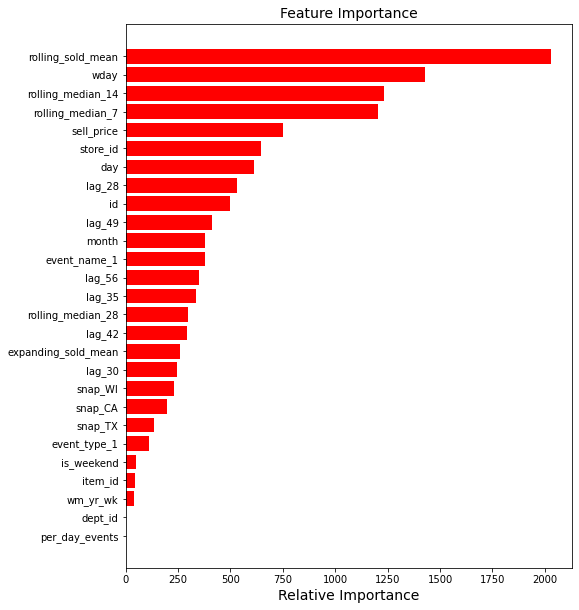

In [ ]:
features=Xtrain.columns
imp=lgb.feature_importances_
indices=(np.argsort(imp))[5:]
plt.figure(figsize=(8,10))
plt.title('Feature Importance',fontsize=14)
plt.barh(range(len(indices)),imp[indices],color='r')
plt.yticks(range(len(indices)),[features[i] for i in indices])
plt.xlabel('Relative Importance',fontsize=14)
plt.show()

In [2]:
pip install tabletext   

  Created wheel for tabletext: filename=tabletext-0.1-cp37-none-any.whl size=6024 sha256=a3db34e164c41242abf6fcf1ac03a253e76b43efb13f823a44dd7b0614943204
  Stored in directory: /root/.cache/pip/wheels/63/15/d8/897b137f43975c4f5f49139be65fee6dbeab6a3f88c1838f66
Successfully built tabletext


In [3]:
#Refernece taken from : https://pypi.org/project/tabletext/
import tabletext

s = [['No.','Model Name','RMSE','Private Score','Public Score'],
        ['1','Linear Regression',1.8061,0.71926 ,0.65149],
        ['2','Decision Tree',2.6658,0.93041 , 0.78754],
        ['3','Decision Trees with Hyperparameters',1.7761,0.68690,0.63487],
        ['4','Random Forest Regressor',1.7624,0.68315,0.61407],
        ['5','XGBoost Regressor',1.7741,0.65077,0.60550],
        ['6','CatBoost Regressor',1.7584,0.65298,0.57053],
        ['7','LightGBM Regressor',1.7459,0.65173,0.56212]
      ]
print(tabletext.to_text(s))

┌─────┬─────────────────────────────────────┬────────┬───────────────┬──────────────┐
│ No. │ Model Name                          │ RMSE   │ Private Score │ Public Score │
├─────┼─────────────────────────────────────┼────────┼───────────────┼──────────────┤
│ 1   │ Linear Regression                   │ 1.8061 │       0.71926 │      0.65149 │
├─────┼─────────────────────────────────────┼────────┼───────────────┼──────────────┤
│ 2   │ Decision Tree                       │ 2.6658 │       0.93041 │      0.78754 │
├─────┼─────────────────────────────────────┼────────┼───────────────┼──────────────┤
│ 3   │ Decision Trees with Hyperparameters │ 1.7761 │        0.6869 │      0.63487 │
├─────┼─────────────────────────────────────┼────────┼───────────────┼──────────────┤
│ 4   │ Random Forest Regressor             │ 1.7624 │       0.68315 │      0.61407 │
├─────┼─────────────────────────────────────┼────────┼───────────────┼──────────────┤
│ 5   │ XGBoost Regressor                   │ 1.7741 │

**Among all the trained models,  LightGBM Regressor performed well.**

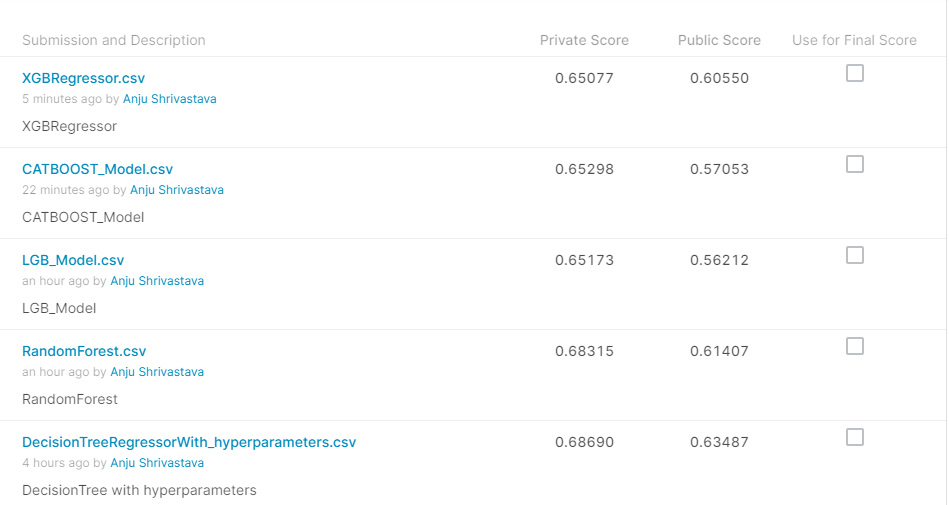

In [ ]:
from IPython.display import Image
Image(filename="Untitled.png")

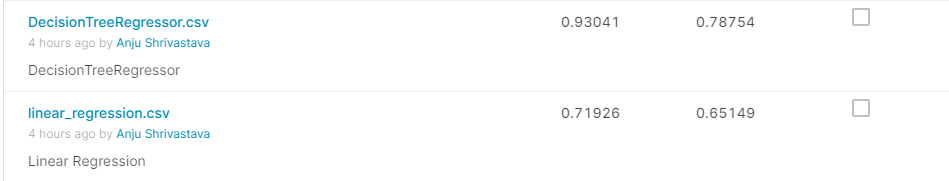

In [77]:
Image(filename="Untitled.png")